## Content
1. Exploratory Visualization
2. Data Cleaning
3. Feature Engineering
4. Modeling & Evaluation
5. Ensemble Methods

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [5]:
# Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
# models
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [6]:
# formating
pd.set_option('max_colwidth',200)
pd.set_option('display.width',200)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.figsize'] = 10, 6

In [20]:
import matplotlib.colors as mpl_colors
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

In [10]:
df = pd.read_csv('wineQT.csv')

In [11]:
df.drop(columns="Id",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


### EDA

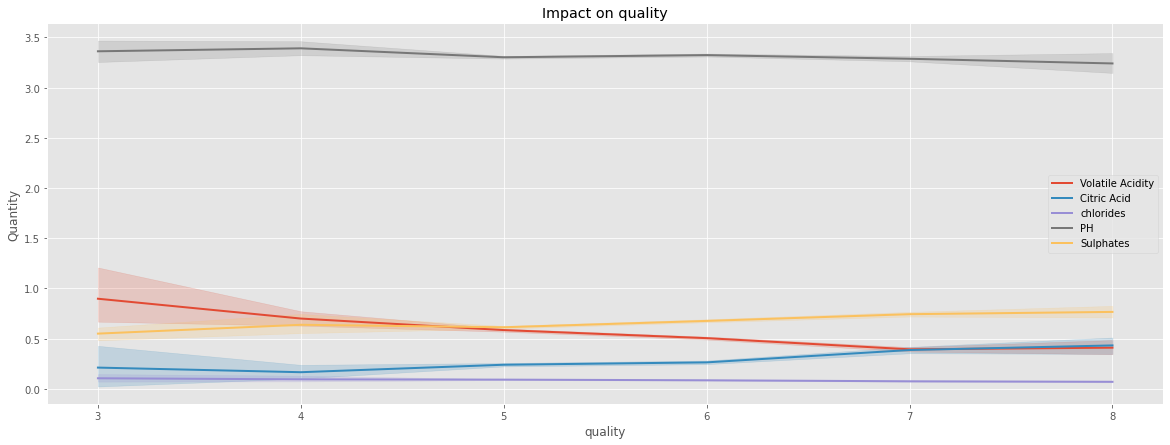

In [12]:
plt.figure(figsize=(20,7))
sns.lineplot(data=df, x="quality",y="volatile acidity",label="Volatile Acidity")
sns.lineplot(data=df, x="quality",y="citric acid",label="Citric Acid")
sns.lineplot(data=df, x="quality",y="chlorides",label="chlorides")
sns.lineplot(data=df, x="quality",y="pH",label="PH")
sns.lineplot(data=df, x="quality",y="sulphates",label="Sulphates")
plt.ylabel("Quantity")
plt.title("Impact on quality")
plt.legend()
plt.show()

In [14]:
import plotly.graph_objects as go
import plotly.express as px
px.scatter(df, x="free sulfur dioxide", y="total sulfur dioxide",animation_frame="quality")


In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop(columns="quality")
y = df["quality"]
# split the data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



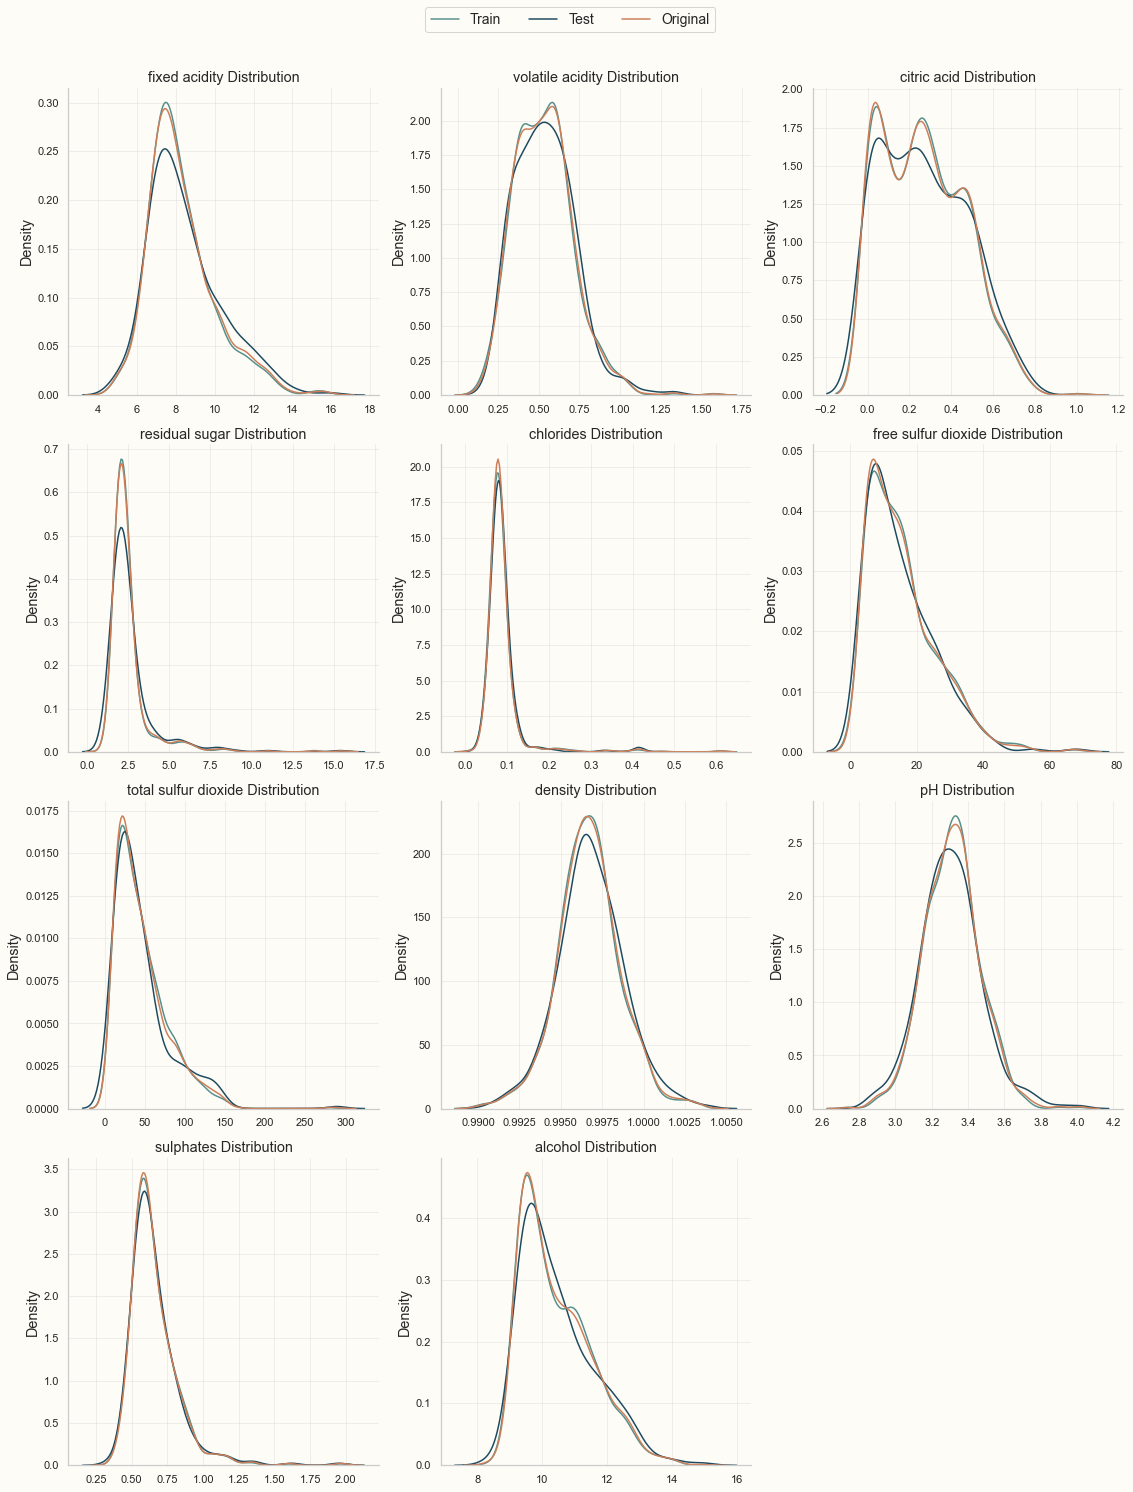

In [21]:
import math
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = X_train.columns
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    
    sns.kdeplot(
        X_train[column], label='Train',
        ax=ax[i], color=colors[1]
    )
    
    sns.kdeplot(
        X_test[column], label='Test',
        ax=ax[i], color=colors[2]
    )
    
    sns.kdeplot(
        df[column], label='Original',
        ax=ax[i], color=colors[3]
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=3)
plt.tight_layout()

### Feature Engineering

In [ ]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["a"] = lab.fit_transform(X["a"])
        X["b"] = lab.fit_transform(X["b"])
        X["c"] = lab.fit_transform(X["c"])
        return X

In [ ]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):

        X["a"] = X["b"] + X["c"]   
        X = X.copy()
        
        ### Time features
        X.reset_index(inplace=True)
        X.sort_values(by='timestamp', inplace=True)
        # extract the market open time every day
        X['date'] = X.timestamp.dt.date
        open_time = X.groupby('date')['timestamp'].min().rename('open_time')
        close_time = X.groupby('date')['timestamp'].max().rename('close_time')
        X = X.merge(open_time, on='date')
        X = X.merge(close_time, on='date')
        X['second_since_open'] = (X['timestamp'] - X['open_time']).dt.total_seconds()
        X['second_till_close'] = (X['close_time'] -X['timestamp']).dt.total_seconds()
        # dummy var for every hour
        X['hour_since_open'] = (X['second_since_open']//3600).astype(int)
        
        # overnight return
        overnight_return = X.diff().groupby(X.date).first()[['xprice', 'yprice']].rename(columns={'xprice': 'x_overnight_return', 'yprice': 'y_overnight_return'})
        
        # day of the week
        X['day_of_week'] = X.timestamp.dt.dayofweek
        X = pd.get_dummies(X, columns=['day_of_week'], prefix='day_of_week')
        
        price_col = 'price'
        long, short = 60, 12
        long_ema = X.groupby(X.index.date)[price_col].apply(lambda X: X.ewm(span=long, adjust=False).mean())
        short_ema = X.groupby(X.index.date)[price_col].apply(lambda X: X.ewm(span=short, adjust=False).mean())
        X[f'{price_col}_{short}_{long}_ewma'] = short_ema - long_ema
    
        return X

Scale the data

In [ ]:

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train.drop('returns', axis=1))

X_test_scaled = scaler.transform(X_test.drop('returns', axis=1))

Feature Importance with Lasso

In [ ]:
model_lasso = Lasso(alpha=0.0001, max_iter=10000)
model_lasso.fit(X_train_scaled, y_train)
FI_lasso = pd.DataFrame({"Feature Importance": model_lasso.coef_}, index=X.columns)
FI_lasso[abs(FI_lasso["Feature Importance"])>1e-4].sort_values("Feature Importance").plot(kind="barh",figsize=(5,10))
plt.xticks(rotation=90)
print(len(FI_lasso[abs(FI_lasso["Feature Importance"])>1e-4]))
plt.show()

PCA

In [ ]:
n = 5
pca = PCA(n_components=n)
train_pca = pca.fit_transform(X_train_scaled)
test_pca = pca.transform(X_test_scaled)
ex_var = pca.explained_variance_ratio_.cumsum()[:10]
print(f'Explained variance: {ex_var}')

Feature Importance with PCA and OLS

In [ ]:
model_ols = LinearRegression()
model_ols.fit(train_pca[:, :n], y_train)
pred_train = model_ols.predict(train_pca[:, :n])
mse_train = mean_squared_error(y_train, pred_train)

pred_test = model_ols.predict(test_pca[:, :n])
mse_test = mean_squared_error(pred_test, y_test)

print(f'MSE train: {mse_train}')
print(f'MSE test: {mse_test}')

print(f'R2 train: {r2_score(y_train, pred_train)}')
print(f'R2 test: {r2_score(pred_test, y_test)}')

In [ ]:
pca_coefficients = model_ols.coef_  # Exclude the intercept term

# The PCA components matrix is the same as the loading matrix
# Each original feature's importance is the dot product of PCA coefficients and loadings
feature_importances = np.dot(pca.components_.T, pca_coefficients)

# Create a DataFrame for easy interpretation
importance_df = pd.DataFrame({
    'importance': feature_importances,
    'abs_importance': np.abs(feature_importances)
}).set_index(X.columns)
importance_df = importance_df.sort_values(by='abs_importance', ascending=False)
colors = ['blue' if value >= 0 else 'red' for value in importance_df['importance']]
importance_df['abs_importance'][:30].plot(kind='bar', figsize=(18, 5), color=colors, rot=45)
plt.tight_layout()


Pipeline

In [ ]:
pipe = Pipeline([ ('scaler', RobustScaler()),
                  ('pca', PCA(n_components=10)),
                   ('model', Lasso(alpha=1))])
model_lasso = pipe.fit(X_train, y_train)

### Evaluation

Grid Search CV

In [ ]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self, X, y, param_grid, scoring = "neg_mean_squared_error"):
        n_splits = 3  # Adjust based on dataset length
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=50000)
        grid_search = GridSearchCV(self.model, param_grid, cv=tscv, scoring=scoring, verbose=1, n_jobs=-1)
        grid_search.fit(X,y)
        print(grid_search.best_params_, -grid_search.best_score_)
        grid_search.cv_results_['mean_test_score'] = -grid_search.cv_results_['mean_test_score']
        results_df = pd.DataFrame(grid_search.cv_results_)

        print(results_df[['params','mean_test_score','std_test_score']])


n = 50
grid(Lasso()).grid_get(train_pca[:, :n], y_train, {'alpha': [0.9, 0.95,1.0, 1.05, 1.1], 'max_iter': [10000]})


CV score

In [ ]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

Select Models using CV scores (not much manual tuning)

In [ ]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

### Ensemble Methods

Average model

In [ ]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mod, weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [ ]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

### Time Series Modeling

Diaganostic plots

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# diaganostic plot for residuals
def plot_diagnosticsTight3(data):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))
    
    ax1.hist(data, bins =40,color='m', density = True)  
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()
    
   
    logData = np.floor(np.log(len(data)))
    ljbox_test = sm.stats.acorr_ljungbox(data,10)#package version issue
    
    ax4.plot(ljbox_test[1])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()
    
    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Resid Sqr")
    
    plt.tight_layout()


Seasonality decompose

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

analysis = df.copy()


decompose_result_mult = seasonal_decompose(analysis, model="additive", period=365)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();